# Advanced Lane Finding
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

Creating a great writeup:
---
A great writeup should include the rubric points as well as your description of how you addressed each point.  You should include a detailed description of the code used in each step (with line-number references and code snippets where necessary), and links to other supporting documents or external references.  You should include images in your writeup to demonstrate how your code works with examples.  

All that said, please be concise!  We're not looking for you to write a book here, just a brief description of how you passed each rubric point, and references to the relevant code :). 

You're not required to use markdown for your writeup.  If you use another method please just submit a pdf of your writeup.

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Camera has distortions, like radial distortion, tangetial distortion, chromatical distortion etc. By comparing the images and original object using cv2 functions, the distortions can be calculated and minimized

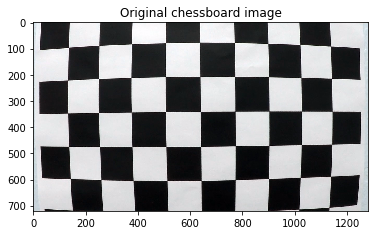

In [67]:
%matplotlib inline
# pick one image to check if 
img = cv2.imread("camera_cal/calibration1.jpg")
plt.imshow(img)
plt.title("Original chessboard image")
plt.show()

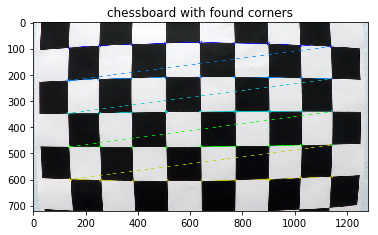

In [7]:
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
# be careful of the 2nd parameter, patternSize=(columns,rows) 
ret, corners = cv2.findChessboardCorners(gray,(9,5),None)

#if found, add object points, image points
if ret == True:
    cv2.drawChessboardCorners(img,(9,5),corners,ret)
    plt.imshow(img)
    plt.title("chessboard with found corners")
    plt.show()

In [8]:
# the above image has 6x 9 corners
nr = 6
nc = 9
# prepare object points, smart idea to use np.mgrid
objp = np.zeros((nr*nc,3),np.float32)
objp[:,:2] = np.mgrid[:nc,:nr].T.reshape(-1,2)
#print(objp)

In [9]:
# use glob to match file with pattern, here the pattern is file extension '.jpg'
calfiles = glob.glob("camera_cal/*.jpg")
# Arrays to store object pongs and image points from all the images
objpoints = [] #3D points with Z axis always 0, Why?
imgpoints = [] #2D points on image, value in pixels

for file in calfiles:
    img = cv2.imread(file)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # be careful of the 2nd parameter, patternSize=(columns,rows) 
    ret, corners = cv2.findChessboardCorners(gray,(nc,nr),None)
    
    #if found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img,(nc,nr),corners,ret)
        #plt.imshow(img)
        #plt.show()
        #print("corners found in file : {}".format(file))
    else:
        print("corners not found in file : {}".format(file))


    

corners not found in file : camera_cal/calibration1.jpg
corners not found in file : camera_cal/calibration4.jpg
corners not found in file : camera_cal/calibration5.jpg


In [10]:
# calibrate camera to get transformation matrix
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,(img.shape[1],img.shape[0]),None,None)

### 2. Apply a distortion correction to raw images.

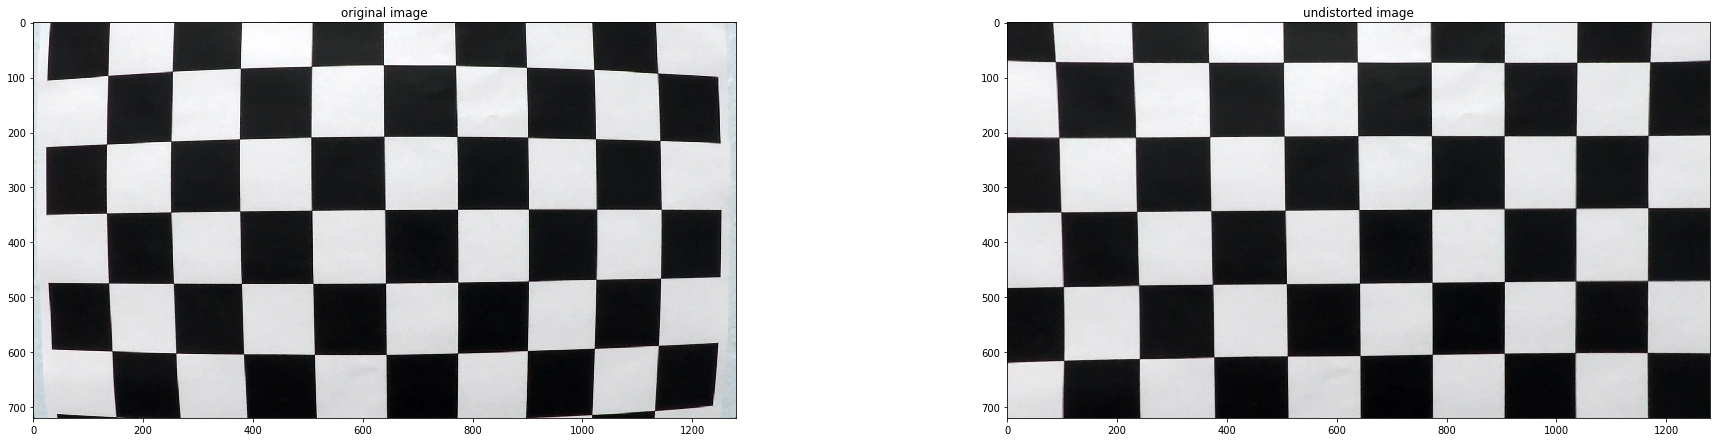

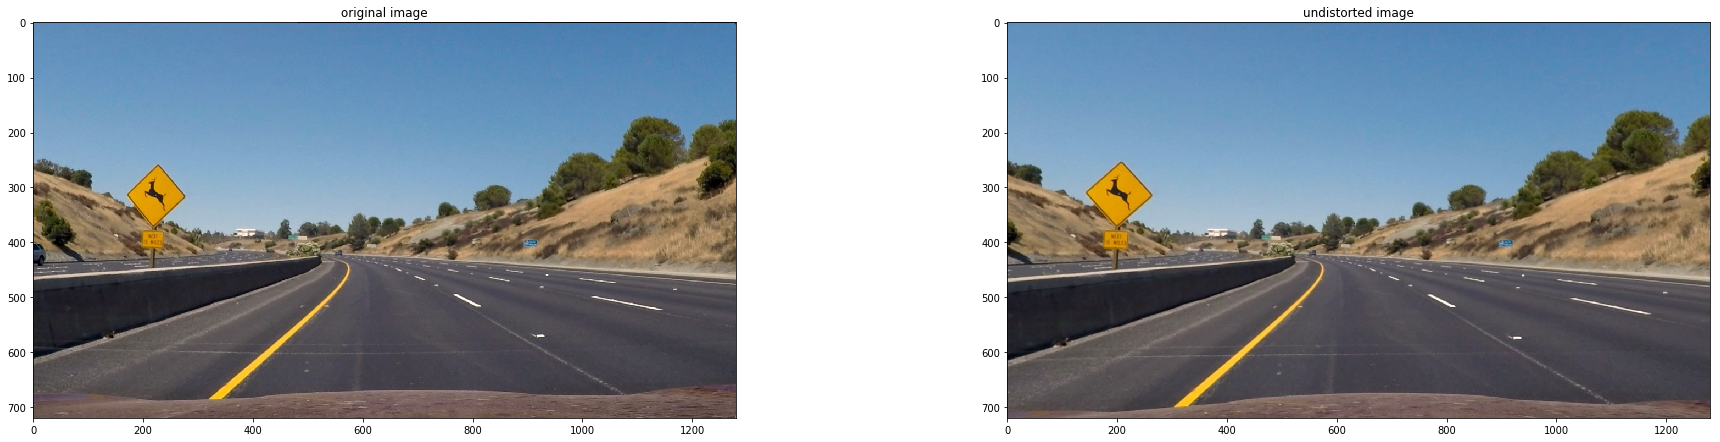

In [15]:
testfiles = glob.glob("test_images/*.jpg")
# check the chessboard image before and after distortion correction
img = cv2.imread("camera_cal/calibration1.jpg")
undist = cv2.undistort(img,mtx,dist,None,mtx)

# plog images
fig = plt.figure(figsize=(32,16))
ax =fig.add_subplot(2,2,1)
ax.imshow(img)
ax.set_title("original image")
ax = fig.add_subplot(2,2,2)
ax.imshow(undist)
ax.set_title("undistorted image")

# pick a test image to check before and after distortion correction
img = cv2.imread(testfiles[1])
undist = cv2.undistort(img,mtx,dist,None,mtx)

# plot the images
fig = plt.figure(figsize=(32,16))
ax =fig.add_subplot(2,2,3)
ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax.set_title("original image")
ax = fig.add_subplot(2,2,4)
ax.imshow(cv2.cvtColor(undist,cv2.COLOR_BGR2RGB))
ax.set_title("undistorted image")

plt.show()

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.     

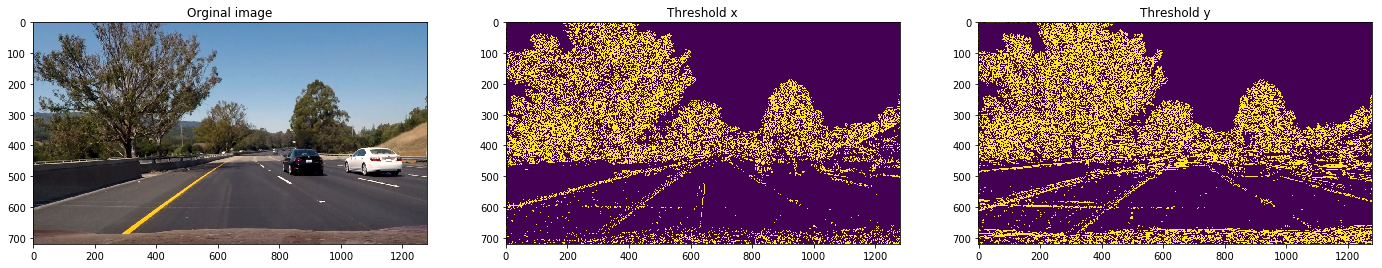

In [469]:
# the image must be in format BGR or BGRA e.g. read by cv2.imread
# since we convert grayscale use pixel format COLOR_BGR2GRAY
def abs_xy_thresh(img,orient='x', sobel_kernel=3,thresh=(0,255)):
    """ apply absolute value thresh hold on a image in x or y direction
    argugments:
    img -- input image
    sobel_kernel -- the sobel kernel size (default 3)
    orient -- orientation, default(x axis)
    thresh -- threshold for low and high magnitude(default 0,255)
    return -- a binary image with gradient within threshold 
    
    """
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    
    sobel = np.abs(sobel)
    binary_output = np.zeros_like(sobel)
    
    binary_output[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
    
    return binary_output

# test mag_thresh
ind = np.random.randint(len(testfiles))
img = cv2.imread(testfiles[ind])

abs_x = abs_xy_thresh(img, orient='x',sobel_kernel=3,thresh=(20,100))
abs_y = abs_xy_thresh(img, orient='y',sobel_kernel=3,thresh=(20,100))

plt.clf()

f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,9))

ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title("Orginal image")
ax2.imshow(abs_x)
ax2.set_title("Threshold x")
ax3.imshow(abs_y)
ax3.set_title("Threshold y")
plt.show()
    

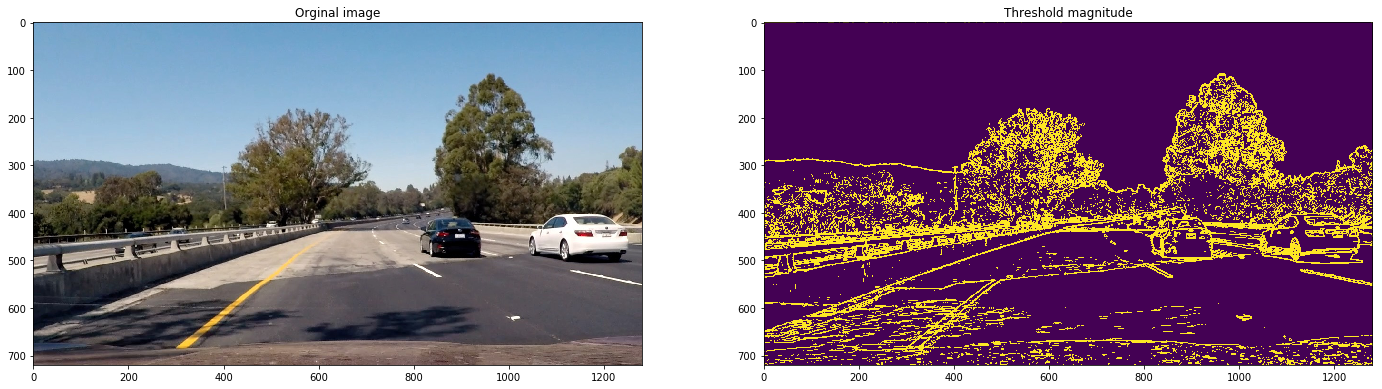

In [106]:
# the image must be in format BGR or BGRA e.g. read by cv2.imread
# since we convert grayscale use pixel format COLOR_BGR2GRAY
def mag_thresh(img,sobel_kernel=3,thresh=(0,255)):
    """ apply magnitude thresh hold on a image
    argugments:
    img -- input image
    sobel_kernel -- the sobel kernel size (default 3)
    thresh -- threshold for low and high magnitude
    return -- a binary image with gradient within threshold 
    
    """
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    sobel= np.sqrt(sobelx**2 + sobely**2)
    sobel_scale = np.uint8(255 * sobel/np.max(sobel))
    binary_output = np.zeros_like(sobel_scale)
    binary_output[(sobel_scale >= thresh[0]) & (sobel_scale <= thresh[1])] = 1
    
    return binary_output

# test mag_thresh
ind = np.random.randint(len(testfiles))
img = cv2.imread(testfiles[ind])

mag_img = mag_thresh(img,sobel_kernel=3,thresh=(20,255))

plt.clf()

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))

ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title("Orginal image")
ax2.imshow(mag_img)
ax2.set_title("Threshold magnitude")

plt.show()
    

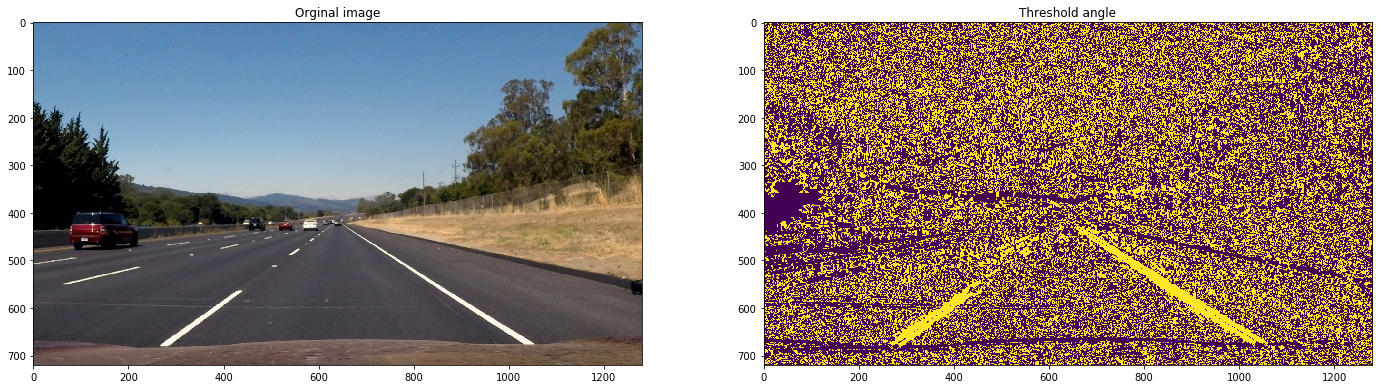

In [107]:
# the image must be in format BGR or BGRA e.g. read by cv2.imread
# since we convert grayscale use pixel format COLOR_BGR2GRAY
def dir_thresh(img,sobel_kernel=3,thresh=(0,np.pi/2)):
    """ apply angle threshold on a image
    argugments:
    img -- input image
    sobel_kernel -- the sobel kernel size (default 3)
    thresh -- threshold for angle to horizon, i.e. horizontal line has angle=0
    return -- a binary image with gradient within angle threshold 
    
    """
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    
    sobel_angle = np.arctan2(np.abs(sobely),np.abs(sobelx))
    
    binary_output = np.zeros_like(sobel_angle)
    binary_output[(sobel_angle >= thresh[0]) & (sobel_angle <= thresh[1])] = 1
    
    return binary_output

# test mag_thresh
ind = np.random.randint(len(testfiles))
img = cv2.imread(testfiles[ind])

dir_img = dir_thresh(img,sobel_kernel=15,thresh=(0.7,1.3))

plt.clf()

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))

ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title("Orginal image")
ax2.imshow(dir_img)
ax2.set_title("Threshold angle")

plt.show()

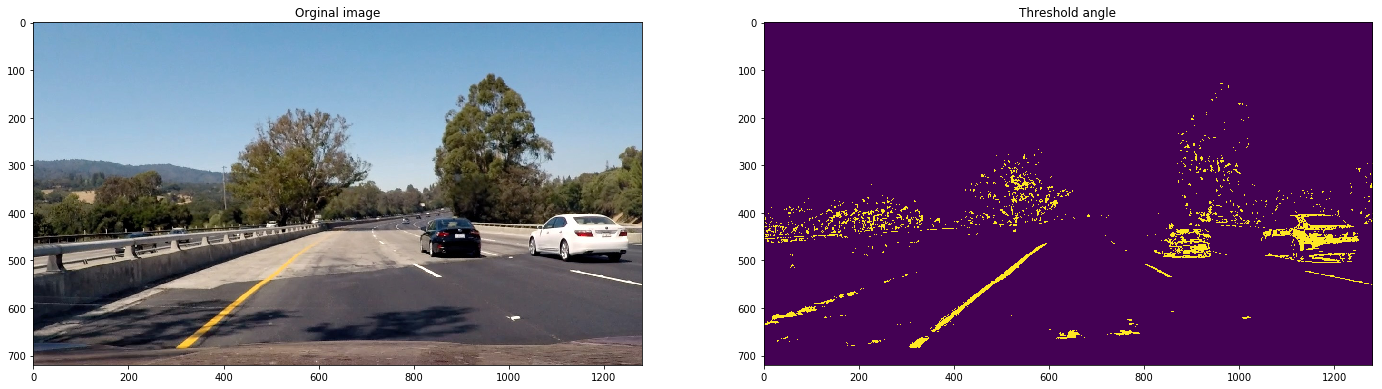

In [255]:
# the image must be in format BGR or BGRA e.g. read by cv2.imread
# since we convert grayscale use pixel format COLOR_BGR2GRAY
def hls_saturation_thresh(img,thresh=(0,255)):
    """ apply saturation threshold on a image
    argugments:
    img -- input image
    thresh -- threshold for saturation channel in hls color space
    return -- a binary image with saturation within angle threshold 
    
    """
    hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    s = hls[:,:,2]

    binary_output = np.zeros_like(s)
    binary_output[(s >= thresh[0]) & (s <= thresh[1])] = 1
    
    
    return binary_output

# test mag_thresh
ind = np.random.randint(len(testfiles))
img = cv2.imread(testfiles[ind])

s_img = hls_saturation_thresh(img,thresh=(150,255))

plt.clf()

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))

ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title("Orginal image")
ax2.imshow(s_img)
ax2.set_title("Threshold angle")

plt.show()

### 4. Apply a perspective transform to rectify binary image ("birds-eye view") 

<IPython.core.display.Javascript object>


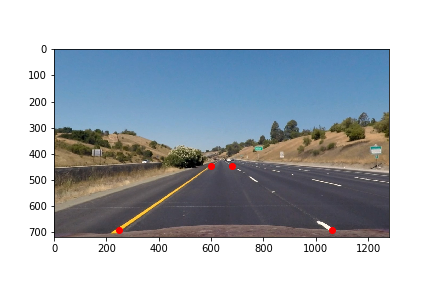

In [456]:
# get matrix of perspective transformation
%matplotlib notebook
# processing image with straight lines
straight_img = mpimg.imread('test_images/straight_lines1.jpg')
straight_img = cv2.undistort(straight_img,mtx,dist,None,mtx)

# source points from image
src = np.float32([[247,691],[601,447],[679,447],[1061,691]])
# target points rectangle
dst = np.float32([[250,720],[250,0],[950,0],[950,720]])

f = plt.figure()
plt.imshow(straight_img)
plt.plot(src[:,0],src[:,1],'ro')
_ = plt.show()


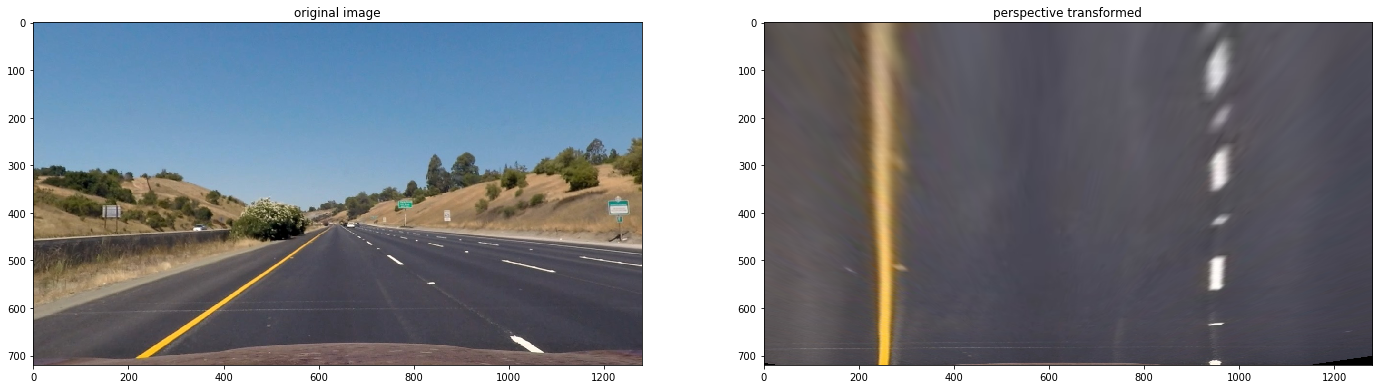

In [457]:
%matplotlib inline

M = cv2.getPerspectiveTransform(src,dst)

img_size = (straight_img.shape[1],straight_img.shape[0])
straight_p_img = cv2.warpPerspective(straight_img,M,img_size,flags=cv2.INTER_LINEAR)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.imshow(straight_img)
ax1.set_title("original image")

ax2.imshow(straight_p_img)
ax2.set_title("perspective transformed")

plt.show()

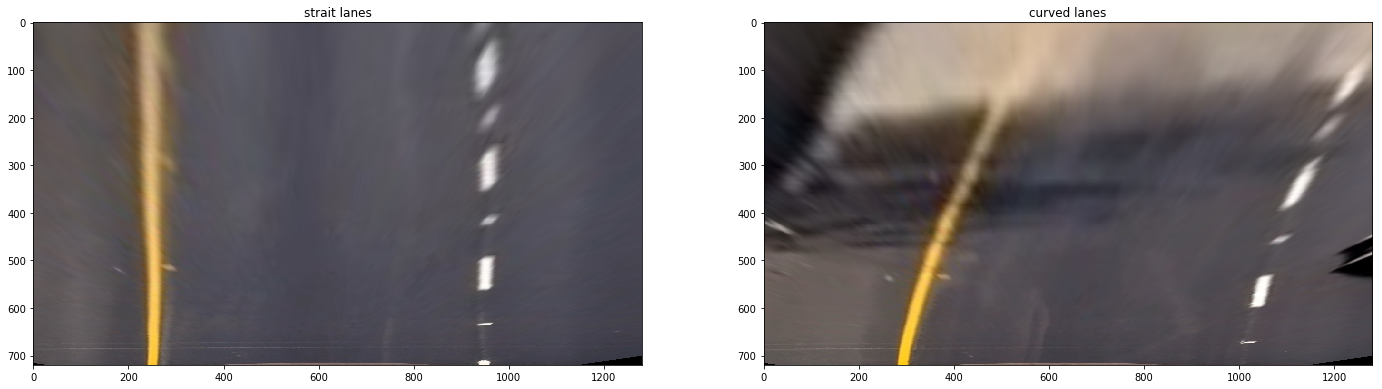

In [458]:
# add perspective transform on curved lanes
curv_img = mpimg.imread('test_images/test6.jpg')
curv_img = cv2.undistort(curv_img,mtx,dist,None,mtx)
curv_img = cv2.warpPerspective(curv_img,M,img_size,flags=cv2.INTER_LINEAR)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.imshow(straight_p_img)
ax1.set_title("strait lanes")
ax2.imshow(curv_img)
ax2.set_title("curved lanes")

plt.show()

### Here is the pipeline to get the binary image for further processing

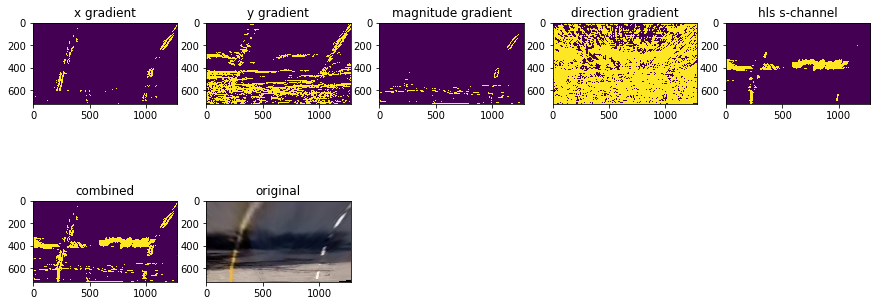

In [491]:
img = mpimg.imread('test_images/test5.jpg')
img = cv2.undistort(img,mtx,dist,None,mtx)
img = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)

absx_img = abs_thresh(img, orient='x',sobel_kernel=3,thresh=(20,100))
absy_img = abs_thresh(img, orient='y',sobel_kernel=3,thresh=(10,100))
mag_img = mag_thresh(img,sobel_kernel=3,thresh=(20,255))
dir_img = dir_thresh(img,sobel_kernel=15,thresh=(0.5,np.pi/2))
s_img = hls_saturation_thresh(img,thresh=(130,255))

combined = np.zeros_like(abs_x)
combined[((absx_img == 1) & (absx_img == 1))] = 1
combined[((mag_img == 1) & (dir_img == 1))] = 1
combined[s_img == 1] =1

plt.figure(figsize=(15,6))
ax = plt.subplot(2,5,1)
plt.imshow(absx_img)
ax.set_title("x gradient")
ax= plt.subplot(2,5,2)
plt.imshow(absy_img)
ax.set_title("y gradient")
ax = plt.subplot(2,5,3)
plt.imshow(mag_img)
ax.set_title("magnitude gradient")
ax = plt.subplot(2,5,4)
plt.imshow(dir_img)
ax.set_title("direction gradient")
ax = plt.subplot(2,5,5)
plt.imshow(s_img)
ax.set_title("hls s-channel")
ax = plt.subplot(2,5,6)
plt.imshow(combined)
ax.set_title("combined")

ax = plt.subplot(2,5,7)
plt.imshow(img)
ax.set_title("original")

plt.show()

#### put all together with gradient and color filtering

In [471]:
def process_img_with_filters(img, x_fil=None,y_fil=None,m_fil=None,a_fil=None,s_fil=None):
    """
    Apply various gradient and color filter to get a binary image
    
    Arguments:
    img -- input image
    x_fil -- abs(x) axis sobel filter parameter, (ksize, low_threshold, high_threshold)
    y_fil -- abs(y) axis sobel filter parameter, (ksize, low_threshold, high_threshold)
    m_fil -- abs(magnitude) sobel filter parameter,(ksize, low_threshold, high_threshold)
    a_fil -- abs(angle in radius) sobel filter parameter,(ksize, low_threshold, high_threshold)
    s_fil -- hls color space s channel filter, (low_threshold, high_threshold)
    return -- a binary image filtered by different options.
    """
    # create binary image for output
    img_bin = np.zeros_like(img[:,:,0])
    absx_bin = img_bin.copy()
    absy_bin = img_bin.copy()
    absm_bin = img_bin.copy()
    dir_bin  = img_bin.copy()
    s_bin    = img_bin.copy()
    
    if x_fil != None:
        absx_bin = abs_xy_thresh(img,orient='x',sobel_kernel = x_fil[0],thresh = (x_fil[1],x_fil[2]))
    if y_fil != None:
        absy_bin = abs_xy_thresh(img,orient='y',sobel_kernel = y_fil[0],thresh = (y_fil[1],y_fil[2]))
    if m_fil != None:
        absm_bin = mag_thresh(img,sobel_kernel = m_fil[0],thresh = (m_fil[1],m_fil[2]))
    if a_fil != None:
        dir_bin = dir_thresh(img,sobel_kernel = a_fil[0],thresh = (a_fil[1],a_fil[2]))
    if s_fil != None:
        s_bin = hls_saturation_thresh(img, thresh = s_fil)
    
    # combine the filters
    # keep both x and y gradients within threshold 
    img_bin[((absx_bin == 1) & (absy_bin == 1))] = 1
    # keep magnitude and direction within threshold 
    img_bin[((absm_bin == 1) & (dir_bin == 1))] = 1
    # keep satuation within threshold
    img_bin[s_bin == 1] = 1
    
    return img_bin
    
    

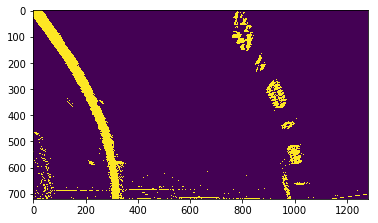

In [504]:
img = mpimg.imread('test_images/test2.jpg')
img = cv2.undistort(img,mtx,dist,None,mtx)
img = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)

img_bin = process_img_with_filters(img,x_fil=(3,10,255),y_fil=(3,10,255),m_fil=(3,20,255),
                                  a_fil=(15,0.5,np.pi/2),s_fil= (120,255))

plt.imshow(img_bin)

### 5. Detect lane pixels and fit to find the lane boundary.

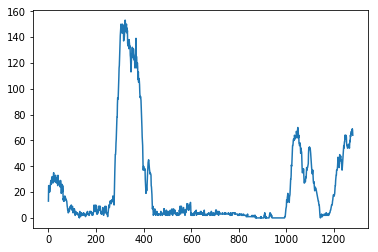

In [526]:
img = mpimg.imread('test_images/test6.jpg')
img = cv2.undistort(img,mtx,dist,None,mtx)
img = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)

img_bin = process_img_with_filters(img,x_fil=(3,10,255),y_fil=(3,10,255),m_fil=(3,20,255),
                                  a_fil=(15,0.5,np.pi/2),s_fil= (120,255))

histogram = np.sum(img_bin[img_bin.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [512]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # y vlaues for plot y
        self.ploty = None
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [544]:
# use window sliding to search the lane from binary image
def detect_lanes(bin_img):
    """
    use window sliding to search the lane from binary image
    Arguments:
    bin_img -- a binary image for lane searching
    return -- left lane and right lane (left,right)
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    img_height = bin_img.shape[0]
    img_width = bin_img.shape[1]
    # middle point x coordinate
    mid_px = img_height//2
    # middle point y coordinate
    mid_py = img_width//2
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img_bin[mid_py:,:], axis=0)
    
    leftx_base = np.argmax(histogram[:mid_px])
    rightx_base = np.argmax(histogram[mid_px:]) + mid_px
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((bin_img, bin_img, bin_img))*255
    # some system will see values as signed  so convert to unsigned byte, 
    out_img = out_img.astype(np.uint8)
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img_height/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_height - (window+1)*window_height
        win_y_high = img_height - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                      (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # mark the lane pixels to be red on left lane and blue on right lane
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img_height-1, img_height )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # here calculate physical curvature
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + 
                           left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + 
                            right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
    
    # assign the values to Line() ojects
    left_lane = Line()
    right_lane = Line()
    left_lane.detected = True
    right_lane.detected = True
    left_lane.current_fit = left_fit
    right_lane.current_fit = right_fit
    left_lane.ploty = ploty
    right_lane.ploty = ploty
    left_lane.recent_xfitted = left_fitx
    right_lane.recent_xfitted = right_fitx
    left_lane.radius_of_curvature = left_curverad
    right_lane.radius_of_curvature = right_curverad
       
    return left_lane,right_lane,out_img

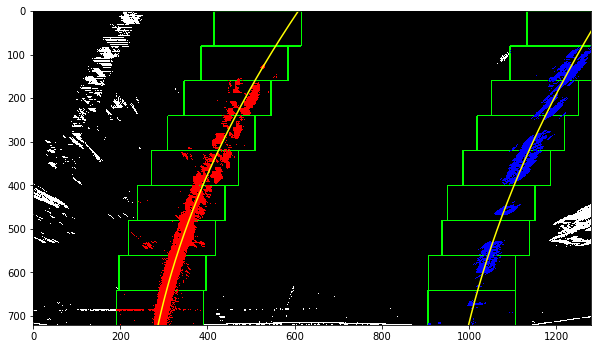

curvature left:522.26m,right:637.26m


In [549]:
# Generate x and y values for plotting
plt.figure(figsize=(10,8))

left_lane,right_lane, out_img = detect_lanes(img_bin)

plt.imshow(out_img)
plt.plot(left_lane.recent_xfitted, left_lane.ploty, color='yellow')
plt.plot(right_lane.recent_xfitted, right_lane.ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.show()
print("curvature left:{:.02f}m,right:{:.02f}m".
      format(left_lane.radius_of_curvature,right_lane.radius_of_curvature))


In [543]:
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def search_lanes(bin_img,previous_lanes=None):
    """
    search the lanes based on previous detected lines
    arguments:
    bin_img -- binary image as input
    previous_lanes -- a tuple of (left,right) Lines to confine the line search area
                     if its value is None, then detect_lanes() is called
    return -- left,right,out_img
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    if previous_lanes == None:
        return detect_lanes(bin_img)
    
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    # get the polyfit parameters from previous image
    left_fit = previous_lanes[0].current_fit
    right_fit = previous_lanes[1].current_fit
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, bin_img.shape[0]-1, bin_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # here calculate physical curvature
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + 
                           left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + 
                            right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((bin_img, bin_img, bin_img))*255
    out_img = out_img.astype(np.uint8)
    window_img = np.zeros_like(out_img, dtype=np.uint8)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # assign the values to Line() ojects
    left_lane = Line()
    right_lane = Line()
    left_lane.current_fit = left_fit
    right_lane.current_fit = right_fit
    left_lane.ploty = ploty
    right_lane.ploty = ploty
    left_lane.recent_xfitted = left_fitx
    right_lane.recent_xfitted = right_fitx
    left_lane.radius_of_curvature = left_curverad
    right_lane.radius_of_curvature = right_curverad
    
    return left_lane,right_lane,out_img

### Test the function ``` python search_lanes() ```

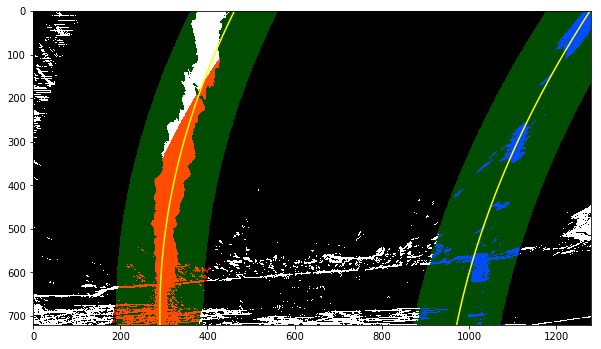

curvature left:462.36m,right:536.27m


In [548]:
# Generate x and y values for plotting
img1 = mpimg.imread('test_images/test3.jpg')
img1 = cv2.undistort(img1,mtx,dist,None,mtx)
img1 = cv2.warpPerspective(img1,M,img_size,flags=cv2.INTER_LINEAR)
img1_bin = process_img_with_filters(img1,x_fil=(3,10,255),y_fil=(3,10,255),m_fil=(3,20,255),
                                  a_fil=(15,0.5,np.pi/2),s_fil= (120,255))
img2 = mpimg.imread('test_images/test4.jpg')
img2 = cv2.undistort(img2,mtx,dist,None,mtx)
img2 = cv2.warpPerspective(img2,M,img_size,flags=cv2.INTER_LINEAR)

img2_bin = process_img_with_filters(img2,x_fil=(3,10,255),y_fil=(3,10,255),m_fil=(3,20,255),
                                  a_fil=(15,0.5,np.pi/2),s_fil= (120,255))

pre_left,pre_right, out_img1 = detect_lanes(img1_bin)
left_lane,right_lane, out_img2 = search_lanes(img2_bin,previous_lanes=(pre_left,pre_right))

out_img = cv2.addWeighted(out_img1, 1, out_img2, 0.3, 0)

plt.figure(figsize=(10,8))
plt.imshow(out_img2)

plt.plot(left_lane.recent_xfitted, left_lane.ploty, color='yellow')
plt.plot(right_lane.recent_xfitted, right_lane.ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.show()

print("curvature left:{:.02f}m,right:{:.02f}m".
      format(left_lane.radius_of_curvature,right_lane.radius_of_curvature))